In [1]:
import numpy as np
import torch as ch
import matplotlib.pyplot as plt
from tqdm import tqdm
from aicsimageio import AICSImage
import ipywidgets as widgets

from confocalQuant.segmentation import (
    show_im,
    load_2D,
    threshold_im,
    update_image,
    load_3D,
    apply_thresh_all_Z,
    do_inference,
    get_anisotropy,
    sigmoid,
    toggle_segmentation,
    extract_channels,
    show_maxproj_with_outlines,
    hide_masks,
    run_med_filter,
    gamma_correct_image,
    int_to_float,
    float_to_int, 
    display_image, 
    on_filter_change, 
    toggle_filters,
    med_filter,
    gamma_correct_channel,
    bgrnd_subtract
    
)
from confocalQuant.quantification import get_im_stats
from cellpose import models

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### Prep the image

In [7]:
# specify channels to load
channels = [0,1,2] # channel order SREBPorTOMM20/NeuN/DAPI

# specify path
path = './data/10252023_Tomm20_matchedcohort/10290265con_4.czi'

# load image
img = AICSImage(path)
out = load_3D(img, channels)

# convert to float
out_float = int_to_float(out)

In [8]:
toggle, median, background_dict, gamma_dict, upper_dict, lower_dict = toggle_filters(out_float)
toggle

In [10]:
background_dict

{0: 97.0, 1: 90.87, 2: 0.0}

In [181]:
# run med filter to remove noise
out_med = run_med_filter(out_float, kernel = 3)

# run background subtraction 
background_dict = {0: 0, 1: 50, 2: 0.0}

out_float_subtract = bgrnd_subtract(out_med, np.array(list(background_dict.values())))


100%|██████████| 37/37 [00:05<00:00,  6.45it/s]


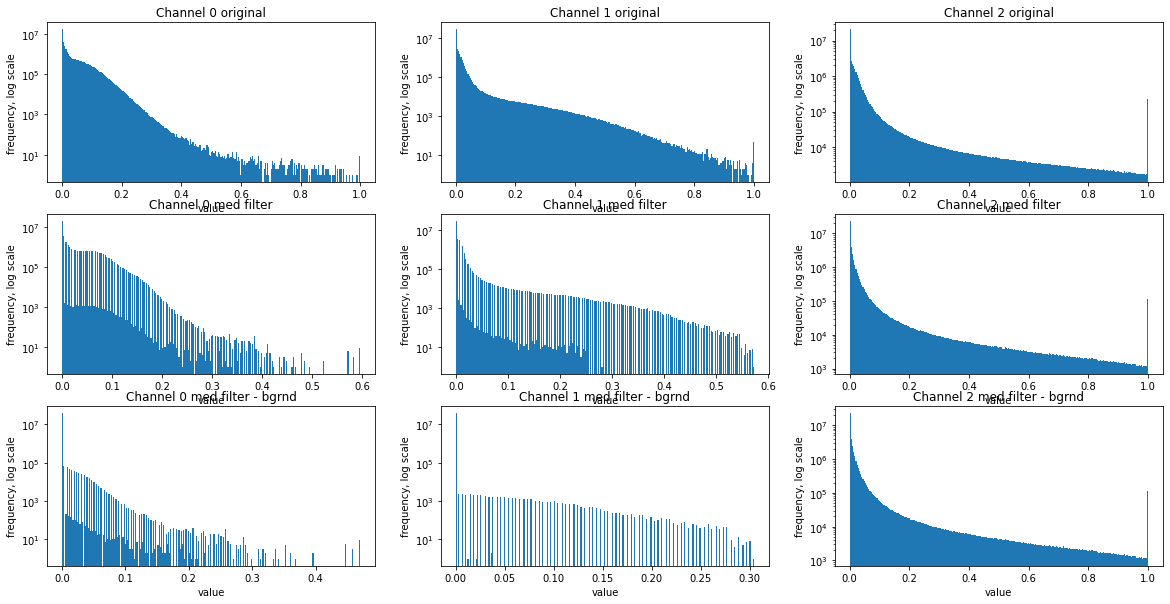

In [56]:
# # show plots
# fig, axs = plt.subplots(3, 3, figsize=(20, 10)) 

# for i in range(out_float.shape[-1]):
#     x = out_float[:,:,:,i].ravel()
#     axs[0,i].hist(x,256)
#     axs[0,i].set_yscale('log')
#     axs[0,i].set_title('Channel ' + str(i) + ' original')
#     axs[0,i].set_xlabel('value')
#     axs[0,i].set_ylabel('frequency, log scale')
#     #axs[0,i].set_ylim(0,0.1e6)
#     #axs[0,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None
    
# for i in range(out_med.shape[-1]):
#     x = out_med[:,:,:,i].ravel()
#     axs[1,i].hist(x,256)
#     axs[1,i].set_yscale('log')
#     axs[1,i].set_title('Channel ' + str(i) + ' med filter')
#     axs[1,i].set_xlabel('value')
#     axs[1,i].set_ylabel('frequency, log scale')
#     #axs[1,i].set_ylim(0,0.1e6)
#     #axs[1,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None

# for i in range(out_float_subtract.shape[-1]):
#     x = out_float_subtract[:,:,:,i].ravel()
#     axs[2,i].hist(x,256)
#     axs[2,i].set_yscale('log')
#     axs[2,i].set_title('Channel ' + str(i) + ' med filter - bgrnd')
#     axs[2,i].set_xlabel('value')
#     axs[2,i].set_ylabel('frequency, log scale')
#     #axs[2,i].set_ylim(0,0.1e6)
#     #axs[2,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None

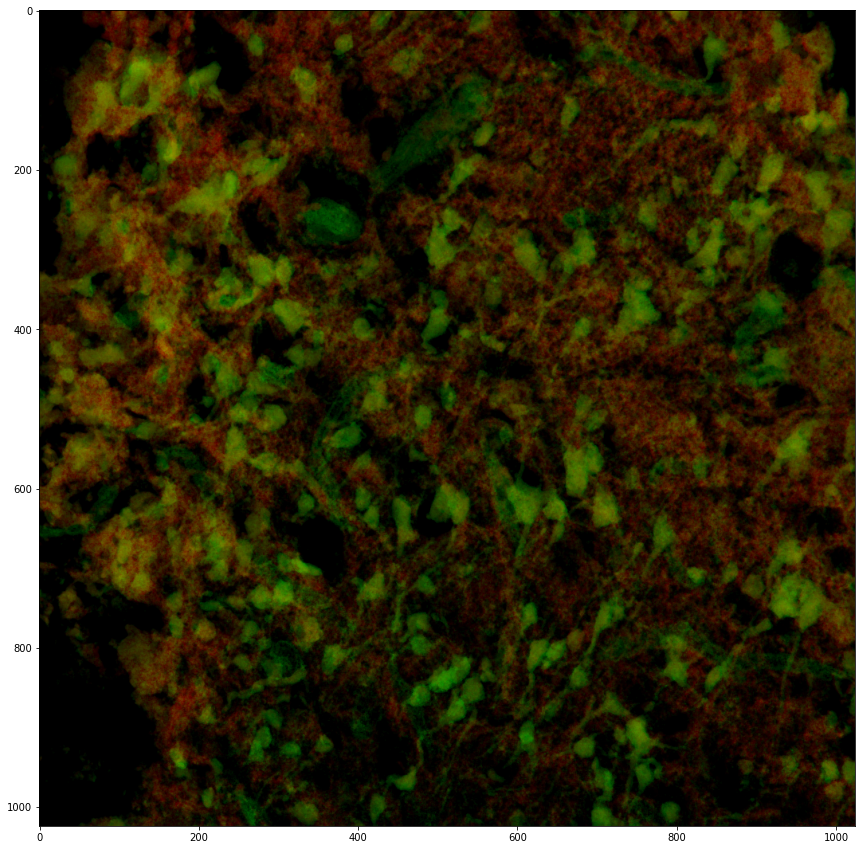

In [96]:
g_correct = gamma_correct_image(out_float_subtract, {0: 1, 1: 0.7, 2: .4}, {0: 0, 1: 0, 2: 0}, {0: 90, 1: 90, 2: 100})

# show projection
out_med_gamma_sele = extract_channels([1,0], g_correct)
out_med_gamma_mean_proj = (np.mean(out_med_gamma_sele, axis=(0)))
plt.figure(figsize = (15,15))
plt.imshow(out_med_gamma_mean_proj)

### Do inference

In [121]:
# get anisotropy
anisotropy = get_anisotropy(img)
print('Anisotropy: ' + str(anisotropy))

# load model
model = models.Cellpose(gpu = True, model_type='cyto2')

# run inference
masks, flows = do_inference(out_float_subtract, do_3D=True, model=model, anisotropy=anisotropy, diameter=20, channels=[2,3], channel_axis=3, z_axis=0, min_size=1100, normalize = False)

Anisotropy: 2.4088670663621183


### Toggle through segmentation

In [122]:
out_float_subtract_g = gamma_correct_image(out_float_subtract, {0: 1, 1: 1, 2: .4}, {0: 0, 1: 0, 2: 0}, {0: 90, 1: 99.5, 2: 100})

In [123]:
# choose which channel(s) to show
out_med_gamma_sele = extract_channels([1], out_float_subtract_g)

# toggle through segmentation
toggle_segmentation(float_to_int(out_med_gamma_sele), masks)

### Show 2D projections

In [215]:
from skimage.segmentation import find_boundaries

def show_maxproj_with_outlines(mat2, masks):
    max_proj = np.mean(mat2, axis=(0))

    for i in tqdm(range(masks.shape[0])):
        M = find_boundaries(masks[i], mode = 'outer', background = 0)
        max_proj[:,:,0][np.where(M)] = 255
        max_proj[:,:,1][np.where(M)] = 255
        max_proj[:,:,2][np.where(M)] = 255


    return max_proj

100%|██████████| 37/37 [00:02<00:00, 15.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 37/37 [00:03<00:00, 11.44it/s]


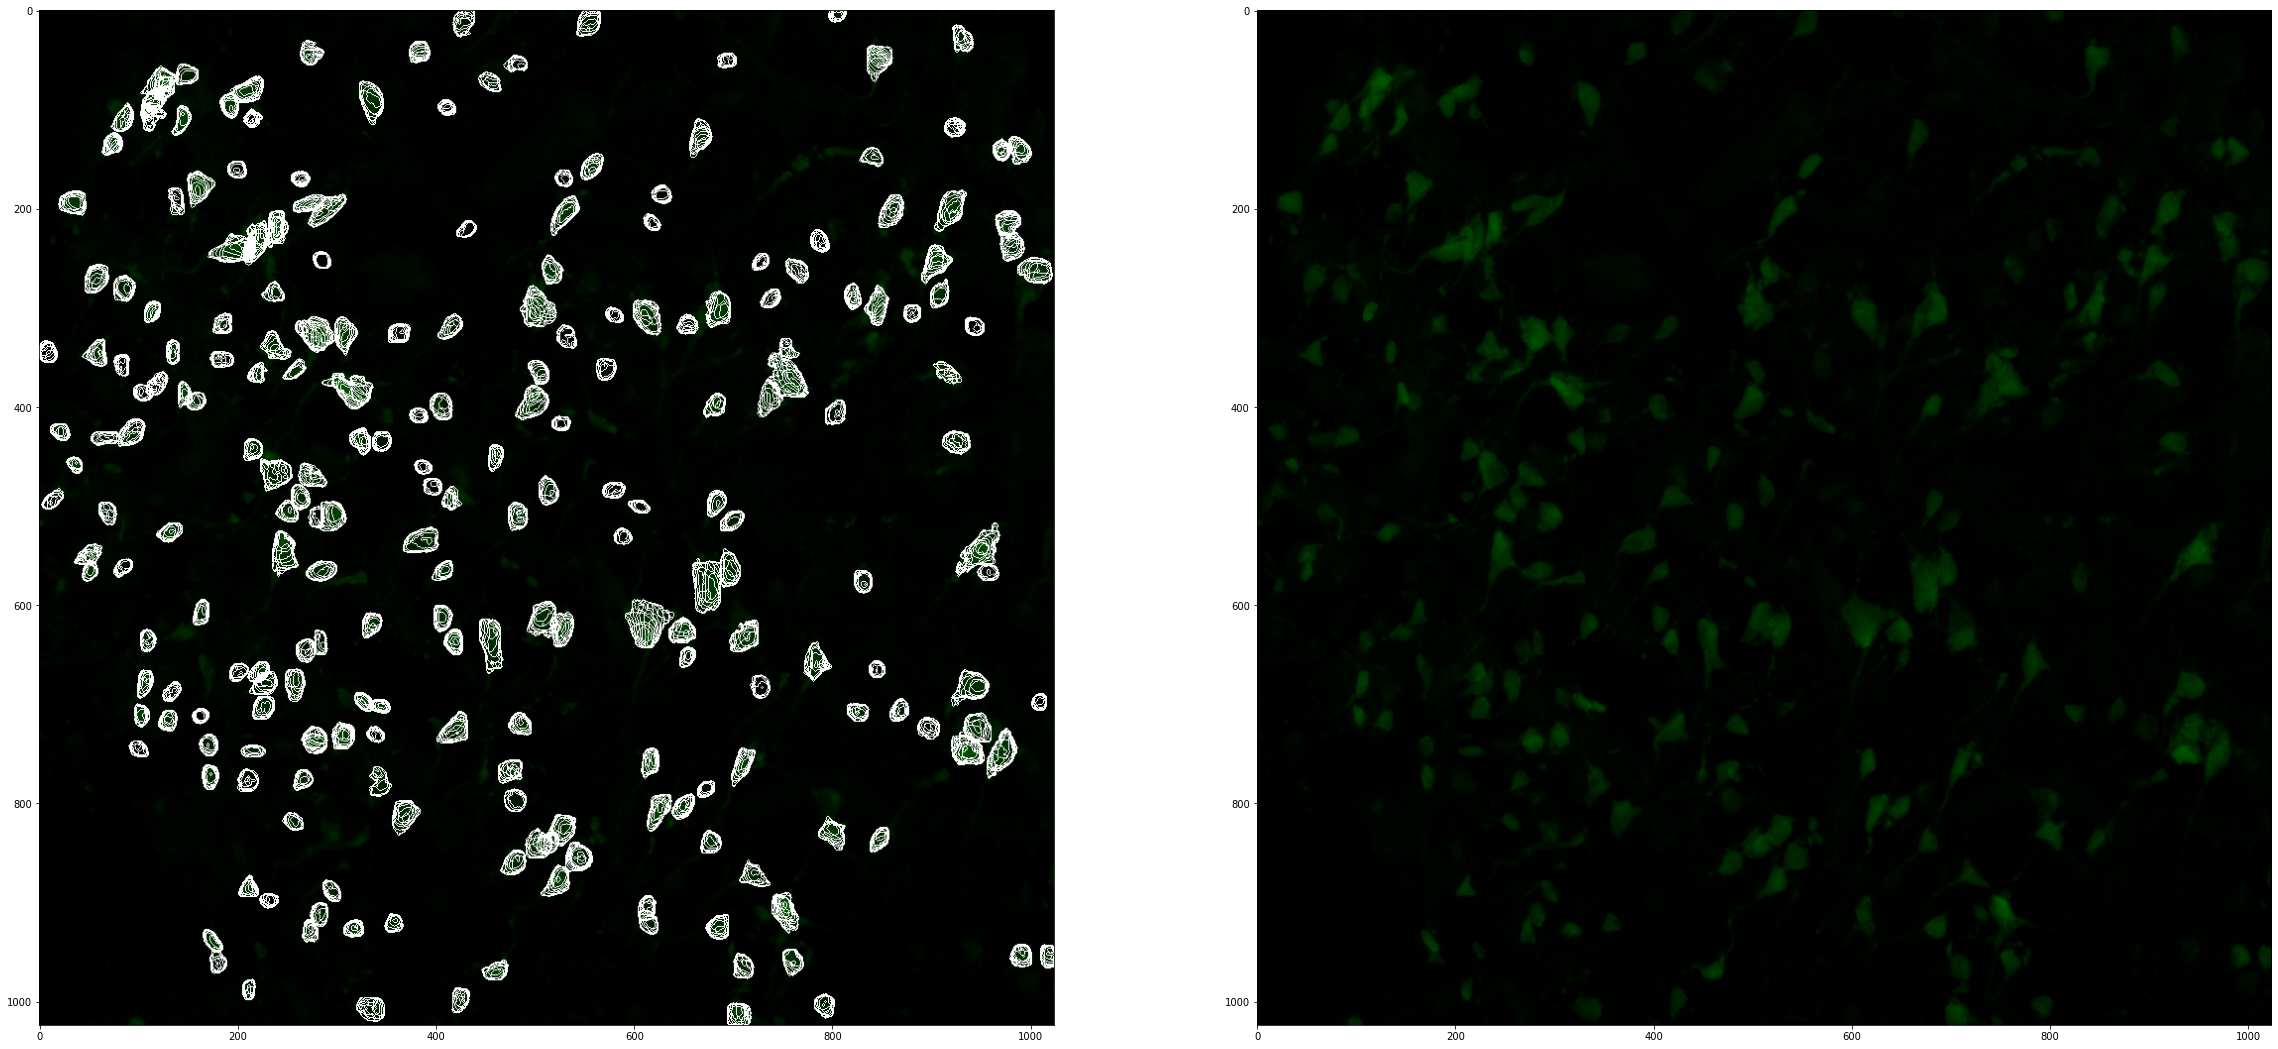

In [125]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks.copy()
masks_temp[masks_temp>0]=0

axs[0].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks)) # make this a mean projection
axs[1].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_temp))

In [ ]:
# subtract background from green channel (x percent) before running model to remove the halucinations due to background
# Do that same subtraction for the channel of interest that we care about (ie. to remove background)
# Don't show max projection, but mean projection

### Get image stats

In [186]:
import numba as nb
def get_per_cell_expectation(matrix, probs, masks, maskID):
    index = masks==maskID
    return np.dot(matrix[index], probs[index])/np.sum(index)

def get_all_expectations(matrix, probs, masks):
    nchannels = matrix.shape[3]
    unique_masks = np.unique(masks)[1:]
    N = len(unique_masks)
    out = np.empty((N,nchannels))

    masks = masks.ravel()
    probs = probs.ravel()
    
    for j in range(nchannels):
        for i in tqdm(range(N)):
            out[i,j] = get_per_cell_expectation(matrix[:,:,:,j].ravel(), probs, masks, unique_masks[i])
    return out

In [188]:
# get expectations
Y = get_all_expectations(out_float_subtract, probs, masks)

100%|██████████| 233/233 [00:52<00:00,  4.46it/s]


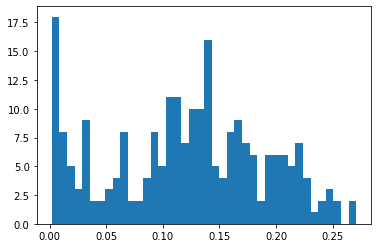

In [195]:
# show hist of NeuN per cell expectations
plt.hist(Y[:,1], 40)
None

In [228]:
# filter based on NeuN
dictionary = dict(zip(range(3), [0, 0.025,0]))

masks_copy = masks.copy()
hide_masks(Y, masks_copy, dictionary)

100%|██████████| 37/37 [00:02<00:00, 18.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 37/37 [00:02<00:00, 16.78it/s]


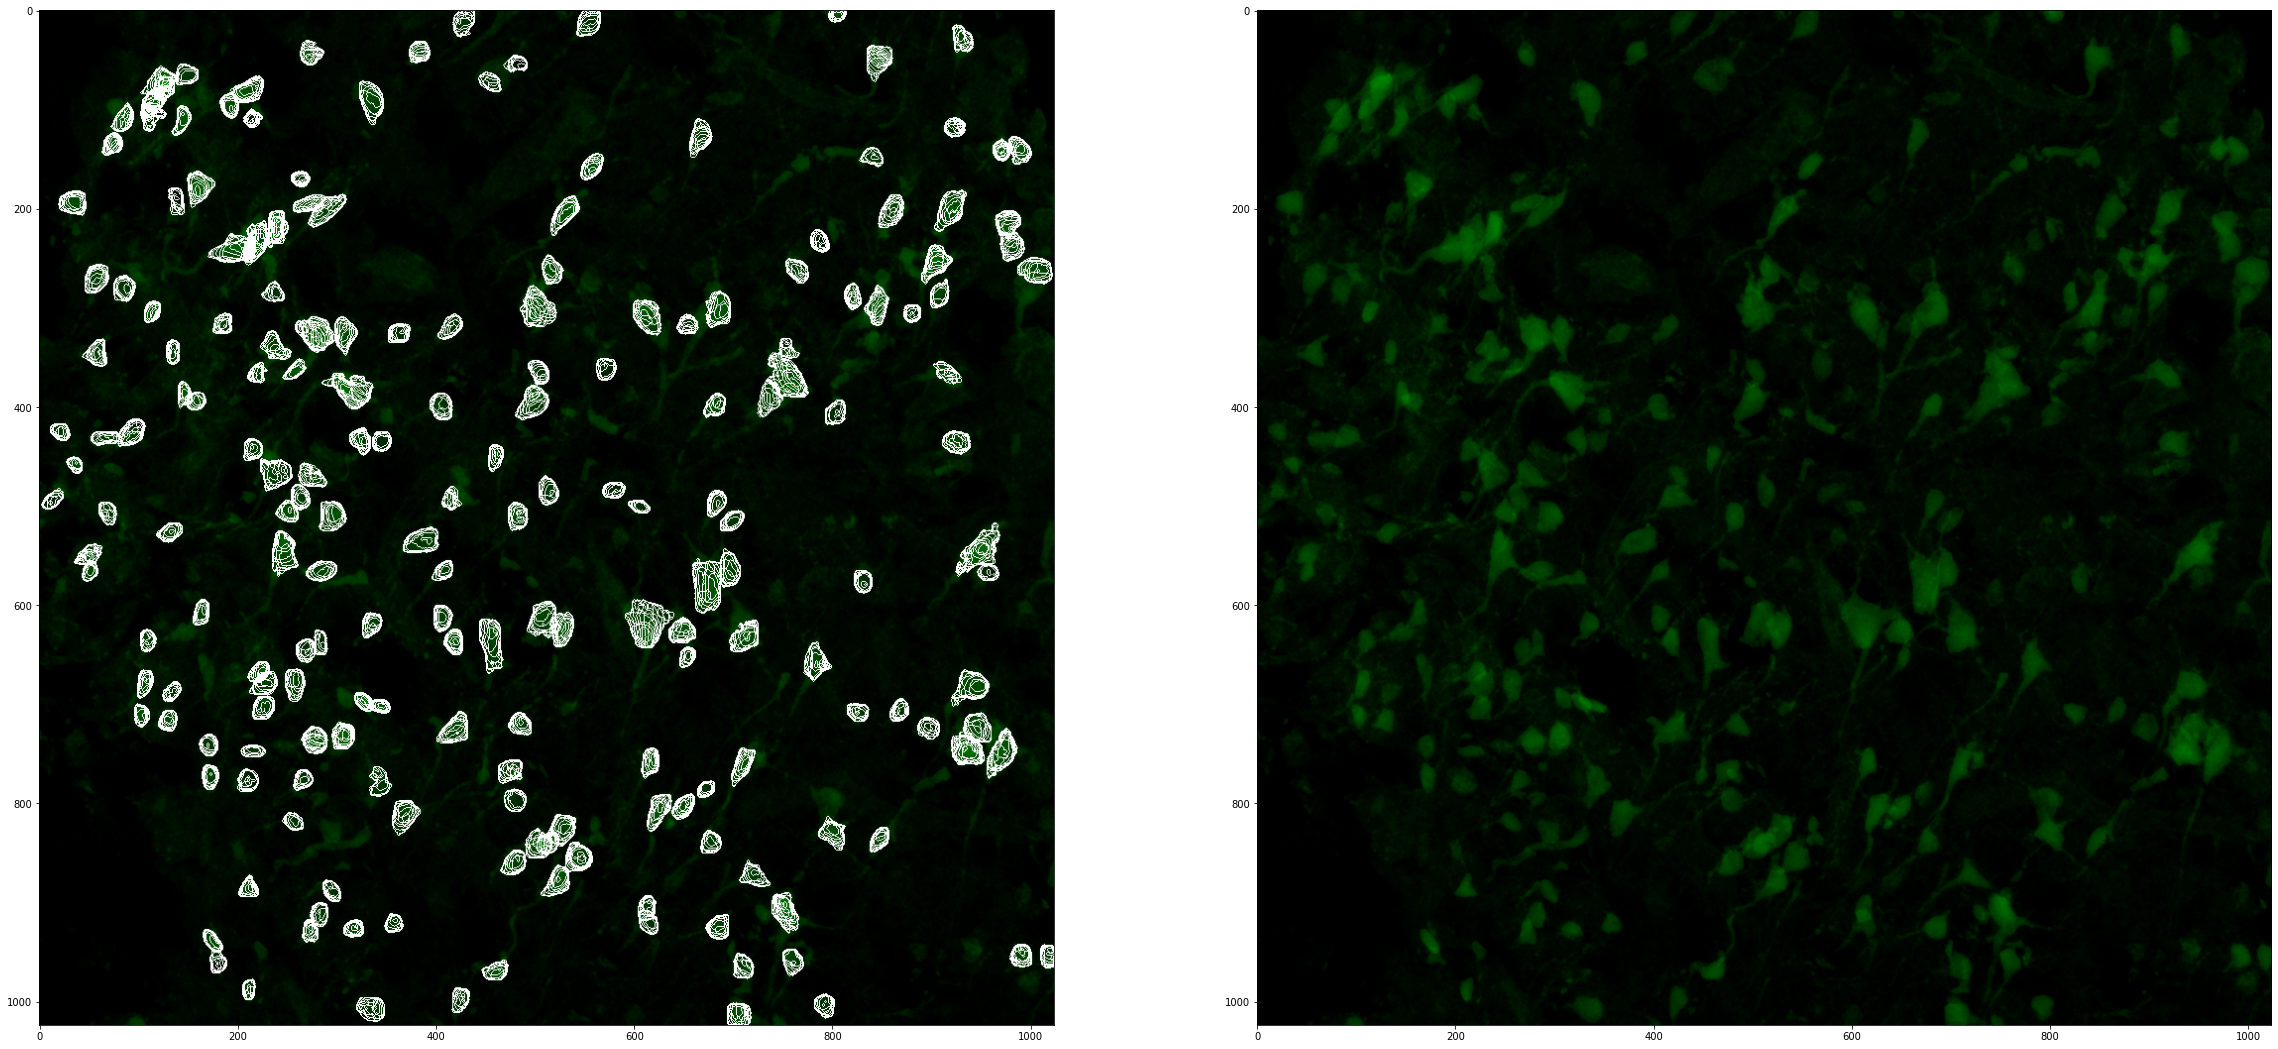

In [229]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks_copy.copy()
masks_temp[masks_temp>0]=0

out_float_subtract_g = gamma_correct_image(out_float_subtract, {0: 1, 1: 1, 2: .4}, {0: 0, 1: 0, 2: 0}, {0: 90, 1: 98.5, 2: 100})
out_med_gamma_sele = extract_channels([1], out_float_subtract_g)

axs[0].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_copy)) # make this a mean projection


axs[1].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_temp))

In [235]:
channel_zero_bgrnd_mean = np.mean(out_float_subtract[:,:,:,0][masks_copy==0])

In [232]:
Y_filtered = Y[Y[:,1]>0.025]

In [246]:
Y_filtered = np.concatenate((Y_filtered, (Y_filtered[:,0]-channel_zero_bgrnd_mean).reshape(-1,1)), axis=1)

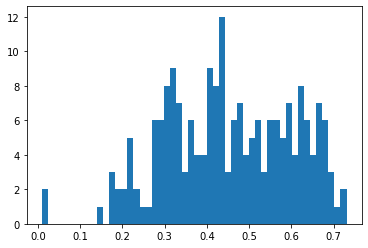

In [255]:
plt.hist(Y_filtered[:,2], 50)
None

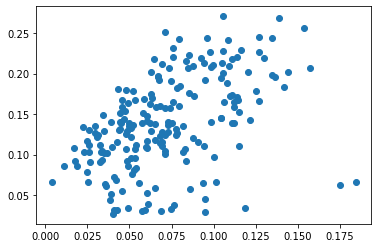

In [258]:
plt.scatter(Y_filtered[:,-1], Y_filtered[:,1])

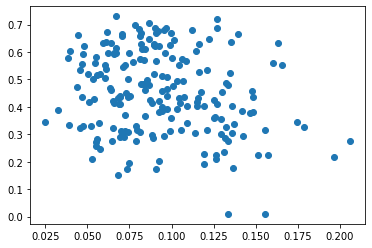

In [259]:
plt.scatter(Y_filtered[:,0], Y_filtered[:,2])